# Coronavirus Spread Prediction

### Problem Statement
Develop an algorithm to predict the spread of the [COVID-19 coronavirus](https://www.who.int/health-topics/coronavirus) in India.



In [1]:
# data analysis and wrangling
import numpy as np
import pandas as pd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# statistical modelling
from scipy import stats
import statsmodels.formula.api as smf

### Acquire data

Let's read the data and have a quick overview of the variables.

- The `Total Confirmed cases` is the outcome/dependent variable that takes on non-negative integral values.
- The `Name of State / UT` is a nominal variable for the name of the state/union territory.
- The `Latitude_ and _Longitude` variables have a one-to-one correspondence to the state/union territory.
    - They must not be treated as qualitative variables since the one-to-one correspondence would make it a mere duplicate of the `Name of State / UT` variable.
- The `date` represents the date in which the observation was recorded.
- The rest of the variables are non-negative integers.

In [2]:
data_path = "../input/"
case_count_details = pd.read_csv(data_path+'covid19-corona-virus-india-dataset/complete.csv')

# preview case count data
print(case_count_details.info())

case_count_details.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 9 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Date                                        1887 non-null   object 
 1   Name of State / UT                          1887 non-null   object 
 2   Total Confirmed cases (Indian National)     1887 non-null   int64  
 3   Total Confirmed cases ( Foreign National )  1887 non-null   int64  
 4   Cured/Discharged/Migrated                   1887 non-null   int64  
 5   Latitude                                    1887 non-null   float64
 6   Longitude                                   1887 non-null   float64
 7   Death                                       1887 non-null   int64  
 8   Total Confirmed cases                       1887 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 132.8+ KB
None


,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
289,2020-03-22,Uttar Pradesh,26,1,9,26.8467,80.9462,0,27
704,2020-04-07,Arunachal Pradesh,0,0,0,28.2180,94.7278,0,1
1234,2020-04-23,Telengana,0,0,194,18.1124,79.0193,23,945
1465,2020-05-01,Arunachal Pradesh,0,0,1,28.2180,94.7278,0,1
1531,2020-05-03,Bihar,0,0,107,25.0961,85.3131,4,481


### Analyze data

- Let's drop the following variables since they won't be used for the prediction: 
    - `Total Confirmed cases ( Foreign National )`
    - `Total Confirmed cases (Indian National)`
- Let's rename the following variables for our ease of usage (and standard):
    - `Name of State / UT` → `region`
    - `Total Confirmed cases` → `confirmed`
    - `Cured/Discharged/Migrated` → `recovered`
    - `Death': 'death', 'Date` → `date`
    - `Latitude` → `latitude`
    - `Longitude` → `longitude`

In [3]:
case_count_details=case_count_details.drop(columns=['Total Confirmed cases ( Foreign National )', 'Total Confirmed cases (Indian National)'], axis=1)
case_count_details=case_count_details.rename(columns = {'Name of State / UT':'region', 'Total Confirmed cases': 'confirmed', 'Cured/Discharged/Migrated': 'recovered', 'Death': 'death', 'Date':'date', 'Latitude':'latitude', 'Longitude':'longitude'})

On analysing the counts of unique values of `region`, we find the following pairs of duplicates:
- Union Territory of Jammu and Kashmir, Jammu and Kashmir
- Union Territory of Ladakh, Ladakh
- Union Territory of Chandigarh, Chandigarh

We resolve the issue by removing the records with the duplicate values.

In [4]:
case_count_details['region'].value_counts()

Kerala                                  105
Telengana                                73
Delhi                                    73
Rajasthan                                71
Uttar Pradesh                            71
Haryana                                  71
Tamil Nadu                               68
Karnataka                                66
Punjab                                   66
Maharashtra                              66
Andhra Pradesh                           63
Uttarakhand                              60
Odisha                                   59
Puducherry                               57
Chhattisgarh                             56
Gujarat                                  55
West Bengal                              55
Ladakh                                   54
Jammu and Kashmir                        54
Madhya Pradesh                           54
Himachal Pradesh                         54
Chandigarh                               54
Bihar                           

In [5]:
remove = ['Union Territory of Ladakh', 'Union Territory of Jammu and Kashmir', 'Union Territory of Chandigarh']
case_count_details = case_count_details[~case_count_details.region.str.contains('|'.join(remove))]

__Issue:__ All the states have unequal number of records in the dataset.

__Workaround__:

- Find the earliest date in the dataset - `overall_first_date`. 
- For each region:
    - Find the latest date in the dataset - `region_last_date` (It can be seen that all states have the same latest date).
    - For each date between `overall_first_date` and `region_last_date`(both dates inclusive)  that is not present in the dataset, insert a copy of the earliest succeeding record with the date modified to the missing date.
    

In [6]:
overall_first_date = datetime.datetime.strptime(min(case_count_details['date']),  '%Y-%m-%d')
overall_last_date = datetime.datetime.strptime(max(case_count_details['date']),  '%Y-%m-%d')
one_day = datetime.timedelta(1)
regions = sorted(case_count_details['region'].unique())
# Storing the latitudes and longitudes in a dictionary - just in case we use them later
region_latitude = {}
region_longitude = {}
to_be_appended = []
for region in regions:
    region_latitude[region] = case_count_details[case_count_details['region']==region].iloc[0]['latitude']
    region_longitude[region] = case_count_details[case_count_details['region']==region].iloc[0]['longitude']
    dates = list(case_count_details[case_count_details['region']==region]['date'])
    region_last_date = datetime.datetime.strptime(dates[-1], '%Y-%m-%d')
    while region_last_date!=overall_first_date:
        prev_record = case_count_details[(case_count_details['region']==region) & (case_count_details['date']==str(region_last_date)[:10])].copy(deep=True)
        if (len(prev_record)==0):
            prev_record = to_be_appended[-1].copy(deep=True)
        region_last_date-=one_day
        if str(region_last_date)[:10] not in dates:
            prev_record.loc[prev_record.index[0], 'date'] = str(region_last_date)[:10]
            to_be_appended.append(prev_record)
case_count_details = pd.concat(to_be_appended+[case_count_details])

To specifically work on the __confirmed__ cases alone, let's create a new dataframe - `region_wise_confirmed`.

In [7]:
region_wise_confirmed = pd.DataFrame(columns=case_count_details['date'].unique(), index = regions)
for i in case_count_details.values:
    region_wise_confirmed.loc[i[1], i[0]] = i[-1] # i[1] - region, i[0] - date, i[-1] - confirmed
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1).T
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1)
region_wise_confirmed

,Andaman and Nicobar Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,Dadar Nagar Haveli,Delhi,Goa,...,Odisha,Puducherry,Punjab,Rajasthan,Tamil Nadu,Telengana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
2020-01-30,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-01-31,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-02-01,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-02-02,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-02-03,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,33,1887,1,59,571,150,59,1,6318,7,...,271,9,1731,3579,6009,1133,118,3214,63,1678
2020-05-10,33,1930,1,63,591,169,59,1,6542,7,...,294,9,1762,3708,6535,1163,134,3373,67,1786
2020-05-11,33,1980,1,63,696,169,59,1,6923,7,...,377,9,1823,3814,7204,1196,150,3467,68,1939
2020-05-12,33,2018,1,65,747,174,59,1,7233,7,...,414,12,1877,3988,8002,1275,152,3573,68,2063


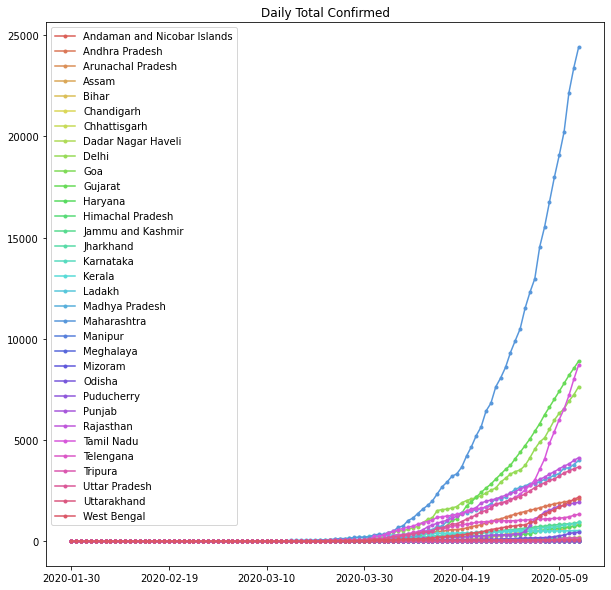

In [8]:
sns.set_palette(sns.color_palette('hls', len(regions)))
region_wise_confirmed.iloc[:,:].plot(marker='.',figsize=(10,10)).set_title('Daily Total Confirmed');

### Preparing the dataset for prediction


Set `num_pred` - the number of days for which we are going to predict the spread.

Stack the dataset with each record the following format - <`date`, `region`, `confirmed`>, sorted by `date`, then `region`.

In [9]:
region_wise_confirmed = region_wise_confirmed.stack().reset_index(name='confirmed')
region_wise_confirmed.columns = ['date', 'region','confirmed']
region_wise_confirmed['date'] = pd.to_datetime(region_wise_confirmed['date'] ,errors ='coerce')

num_pred = 5
for _ in range(num_pred):
    for region in regions:
        region_wise_confirmed=region_wise_confirmed.append({'date':overall_last_date+one_day, 'region':region, 'confirmed':1}, ignore_index=True)
    overall_last_date+=one_day

region_wise_confirmed = region_wise_confirmed.sort_values(['region', 'date'])
region_wise_confirmed = region_wise_confirmed.reset_index(drop=True)
region_wise_confirmed

,date,region,confirmed
0,2020-01-30,Andaman and Nicobar Islands,1
1,2020-01-31,Andaman and Nicobar Islands,1
2,2020-02-01,Andaman and Nicobar Islands,1
3,2020-02-02,Andaman and Nicobar Islands,1
4,2020-02-03,Andaman and Nicobar Islands,1
...,...,...,...
3625,2020-05-14,West Bengal,1
3626,2020-05-15,West Bengal,1
3627,2020-05-16,West Bengal,1
3628,2020-05-17,West Bengal,1


### Using a Kalman Filter to predict `confirmed`

We have noisy and limited data on what we intend to predict - the number of confirmed cases.  Every observed point is an output of a noisy system at a point in time. Therefore, we are most interested in the likely state of the system as of the last observation, given all the observations. 

> In statistics and control theory, __Kalman filtering__, also known as __linear quadratic estimation__ (__LQE__), is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe.

Let's use a Kalman filter to model the dynamics of the coronavirus spread!

In [10]:
# Kalman Filters in detail: http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman filter.pdf

region_wise_confirmed['kalman_prediction'] = 0
phi = np.eye(2)
phi[0][1]=0.45
Q = np.array([[0.00010252, 0.00045563], [0.00045563, 0.002025  ]]) # Found the params in https://github.com/Rank23/COVID19/blob/master/COVID19%20Prediction.ipynb
H = np.array([[1., 0.]])
R = 0.01
for pred in range(num_pred):
    for region in regions:
        inp = list(region_wise_confirmed[region_wise_confirmed['region']==region]['confirmed'].values)
        inp = inp[:len(inp)+1-num_pred+pred]
        kalman_prediction = []
        inp=inp[:len(inp)-pred-1] +list(region_wise_confirmed[region_wise_confirmed['region']==region]['kalman_prediction'].values)[len(inp)-1-pred:len(inp)-1]+[1]
        X = np.array([0,0])[:, np.newaxis]
        P = np.eye(2)
        for z in inp:
            P_prime = np.matmul(phi, np.matmul(P, phi.T))+Q
            X_prime = np.matmul(phi, X)
            K = np.matmul(P_prime, np.matmul(H.T, 1/(np.matmul(H, np.matmul(P_prime, H.T))+R)))
            X = X_prime + K * (z - np.matmul(H, X_prime))
            P = P_prime - np.matmul(K*H, P_prime)
            kalman_prediction.append(np.round(X_prime[0]))
        region_wise_confirmed.loc[region_wise_confirmed['region']==region,'kalman_prediction']=kalman_prediction+[1]*(num_pred-pred-1)

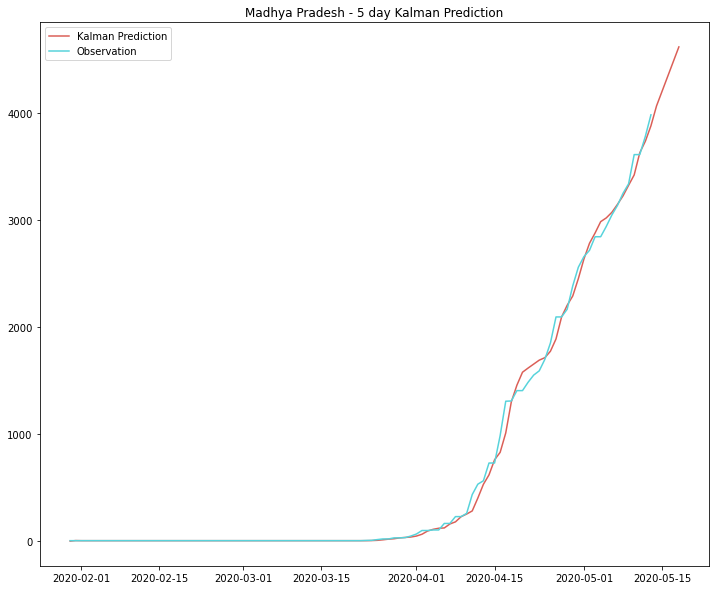

In [11]:
# Pick a region of your choice
sns.set_palette(sns.color_palette("hls", 2))
region = "Madhya Pradesh"
plt.figure(figsize=(12,10))
region_data = region_wise_confirmed[region_wise_confirmed['region']==region]
plt.plot(region_data['date'], region_data['kalman_prediction']);
plt.plot(region_data['date'][:-num_pred], region_data['confirmed'][:-num_pred]);
plt.legend(['Kalman Prediction', 'Observation']);
plt.title('%s - %d day Kalman Prediction' % (region, num_pred));

### Modelling and Prediction

We have a regression problem in hand. Regression analysis produces a regression equation representing the relationship between the predictor variables and the response variable. We then use the regression equation to compute the predictions.

Before the regression analysis, let's add some publicly available region-wise data like `poverty`, `gender_ratio`, `population` and `literacy_rate`. 

Also, we should convert qualitative variables like `date` and `region` to quantitative variables for mathematical analysis. There are multiple ways to encode categorical variables; we will use the following:

- `date`→`num_days_from_start`
- encode `region` between `0` and `len(regions)-1`


In [12]:
region_details = pd.read_csv(data_path+'indian-states-and-union-territories/region_details.csv')
region_wise_confirmed = pd.merge(region_wise_confirmed, region_details,how='left' ,on=['region'])
for i in range(len(region_wise_confirmed)):
    region_wise_confirmed.iloc[i,0] = int((region_wise_confirmed.iloc[i,0]-overall_first_date).days)
region_wise_confirmed=region_wise_confirmed.rename(columns={'date': 'num_days_from_start'})
region_mapping = {region:index for index,region in enumerate(regions)}
region_wise_confirmed['region'] = region_wise_confirmed['region'].map(region_mapping) 
region_wise_confirmed

,num_days_from_start,region,confirmed,kalman_prediction,population,rural_population,urban_population,area,density,gender_ratio,literacy_rate,poverty,hdi
0,0,0,1,0,380581,237093,143488,8249,46.0,876,86.27,1.00,0.739
1,1,0,1,1,380581,237093,143488,8249,46.0,876,86.27,1.00,0.739
2,2,0,1,1,380581,237093,143488,8249,46.0,876,86.27,1.00,0.739
3,3,0,1,1,380581,237093,143488,8249,46.0,876,86.27,1.00,0.739
4,4,0,1,1,380581,237093,143488,8249,46.0,876,86.27,1.00,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,105,32,1,2306,91276115,62183113,29093002,88752,1029.0,953,77.08,13.98,0.641
3626,106,32,1,2433,91276115,62183113,29093002,88752,1029.0,953,77.08,13.98,0.641
3627,107,32,1,2559,91276115,62183113,29093002,88752,1029.0,953,77.08,13.98,0.641
3628,108,32,1,2686,91276115,62183113,29093002,88752,1029.0,953,77.08,13.98,0.641


#### Split Train and Test data
Based on the value of `num_days_from_start`, the train and test datasets are generated. 

In [13]:
delta = (overall_last_date-overall_first_date).days
test = region_wise_confirmed[region_wise_confirmed['num_days_from_start']>delta-num_pred].drop(['confirmed'], axis=1).apply(pd.to_numeric)
train = region_wise_confirmed[region_wise_confirmed['num_days_from_start']<=delta-num_pred].apply(pd.to_numeric)
print ('Train size: %d' %len(train))
print ('Test size: %d' %len(test))

Train size: 3465
Test size: 165


> If the p-value is less than the significance level, the sample data provides sufficient evidence to conclude that the regression model fits the data better than the model with no independent variables. 
- A p-value ≤ 0.05 is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random).

> If the overall F-test is statistically significant(F-statistic > F critical value), the model’s predictions are an improvement over using the mean of the dependent variable.


On inspecting the results, we find that
- many variables have very large p-values => no statistical significance. 
    - we can attribute this to the existence of one-to-one correspondence between some of the variables. 
- Prob (F-statistic) = 0 => F-test is statistically significant.

In [14]:
smf.ols(formula='confirmed ~ num_days_from_start + region + kalman_prediction + population + rural_population + urban_population + area + density + gender_ratio + literacy_rate + poverty + hdi', data=train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              confirmed   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.756e+05
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        08:38:24   Log-Likelihood:                -17711.
No. Observations:                3465   AIC:                         3.545e+04
Df Residuals:                    3453   BIC:                         3.552e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -20.3334     23.617     -0.861      0.389     -66.638      25.971
num_days_from_start     0.0262      0.024      1.093      0.274      -0.021       0.073
region                 -0.0581      0.087     -0.666      0.505      -0.229       0.113
kalman_prediction       1.0176      0.001   1757.883      0.000       1.016       1.019
population           7.524e-09   4.04e-07      0.019      0.985   -7.85e-07       8e-07
rural_population    -1.464e-07   4.25e-07     -0.344      0.731    -9.8e-07    6.87e-07
urban_population     6.925e-07   3.86e-07      1.793      0.073   -6.49e-08    1.45e-06
area                -1.371e-05   1.19e-05     -1.154      0.249    -3.7e-05    9.58e-06
density                -0.0006      0.000     -1.885      0.059      -0.001    2.56e-05
gender_ratio           -0.0032      0.012     -0.268      0.789      -0.027       0.020
literacy_rate           0.1971      0.151      1.303      0.193      -0.099       0.494
poverty                 0.1026      0.087      1.183      0.237      -0.068       0.273
hdi                     7.1415     28.866      0.247      0.805     -49.455      63.737
==============================================================================
Omnibus:                     3237.138   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           843417.677
Skew:                           3.771   Prob(JB):                         0.00
Kurtosis:                      79.059   Cond. No.                     1.35e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.67e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

> Fit a new linear regression model with the statistically significant variables and predict.

__Drawbacks__: 
- Multicolinearity of variables
- Qualitative nature of certain variables

In [15]:
lm = smf.ols(formula='confirmed ~ kalman_prediction + rural_population + urban_population + density', data=train).fit()
region_wise_confirmed.iloc[region_wise_confirmed[region_wise_confirmed['num_days_from_start']>delta-num_pred].index, 2] = np.round(lm.predict(test))

In [16]:
for i in range(len(region_wise_confirmed)):
    region_wise_confirmed.iloc[i,0] = overall_first_date+one_day*int(region_wise_confirmed.iloc[i,0])
region_wise_confirmed=region_wise_confirmed.rename(columns={'num_days_from_start': 'date'})
inverse_region_mapping = {region_mapping[i]:i for i in region_mapping}
region_wise_confirmed['region'] = region_wise_confirmed['region'].map(inverse_region_mapping)

In [17]:
temp = region_wise_confirmed.copy(deep=True)

region_wise_confirmed = pd.DataFrame(columns=temp['date'].unique(), index = regions)
region_wise_kalman_pred = pd.DataFrame(columns=temp['date'].unique(), index = regions)
for i in temp.values:
    region_wise_confirmed.loc[i[1], i[0]] = i[2] # i[1] - region, i[0] - date, i[2] - confirmed
    region_wise_kalman_pred.loc[i[1], i[0]] = i[3] # i[1] - region, i[0] - date, i[3] - kalman prediction
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1).T
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1)
region_wise_kalman_pred = region_wise_kalman_pred.reindex(sorted(region_wise_kalman_pred.columns), axis=1).T
region_wise_kalman_pred = region_wise_kalman_pred.reindex(sorted(region_wise_kalman_pred.columns), axis=1)

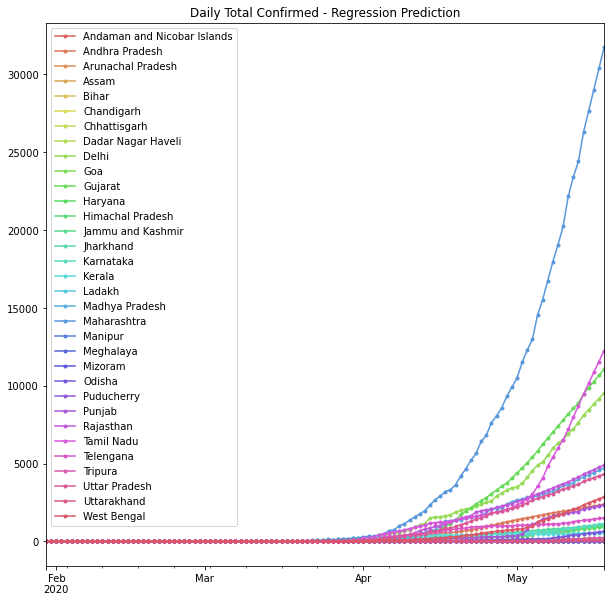

In [18]:
sns.set_palette(sns.color_palette('hls', len(regions)))
region_wise_confirmed.iloc[:,:].plot(marker='.',figsize=(10,10)).set_title('Daily Total Confirmed - Regression Prediction');

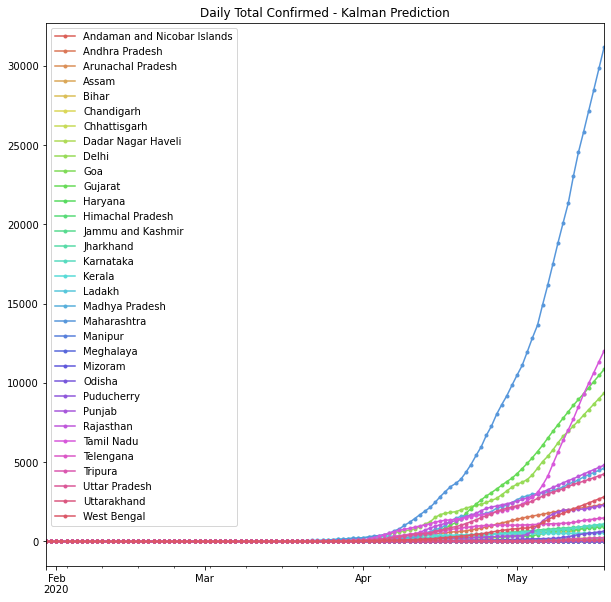

In [19]:
sns.set_palette(sns.color_palette('hls', len(regions)))
region_wise_kalman_pred.iloc[:,:].plot(marker='.',figsize=(10,10)).set_title('Daily Total Confirmed - Kalman Prediction');